In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner

print("Before, figure default size is: ", plt.rcParams["figure.figsize"])
plt.rcParams["figure.figsize"] = (4, 3)
print("After, figure default size is: ", plt.rcParams["figure.figsize"])

Before, figure default size is:  [6.4, 4.8]
After, figure default size is:  [4.0, 3.0]


9.982291097394208 3.112840791127943


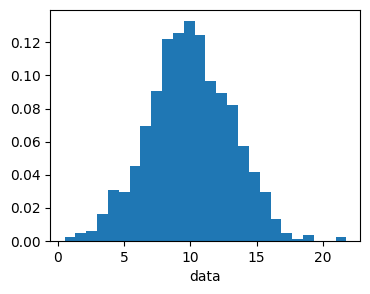

In [2]:
N = 1000
data = np.random.normal(loc=10, scale=3.0, size=N) + np.random.uniform(-1,1,N)#np.random.random(N)

bin_heights, bin_borders, _ = plt.hist(data, bins='auto',range=(min(data),max(data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('data')
print(np.mean(data),np.std(data))

In [3]:
def log_likelihood(params, x):
    std, mu = params
    Ac = -0.5*((x - mu)/std)**2
    y = 1/(np.sqrt(2 * np.pi * std**2)) * np.exp( Ac )
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    std, mu = params
    if 0.0 < std < 10.0 and 0.0 < mu < 20.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return - np.inf
    return lp + log_likelihood(params, x)

def get_gelman_rubin(chain):
    ssq = np.var(chain, axis=0, ddof=1)
    W = np.mean(ssq, axis=0)
    theta_mean = np.mean(chain, axis=1)
    theta_m = np.mean(theta_mean, axis=0)
    M = chain.shape[0]
    N = chain.shape[1]
    B = N / (M - 1) * np.sum((theta_m - theta_mean)**2, axis=0)
    V = (N - 1) / N * W + 1 / N * B
    R = np.sqrt(V / W)
    return R

In [4]:
sample_data = data
std, mu = np.std(sample_data), np.mean(sample_data)
initparams = [std, mu]
print(initparams)
print(log_likelihood(initparams, sample_data))
print(log_prior(initparams))
print(log_probability(initparams, sample_data))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results.x

[3.112840791127943, 9.982291097394208]
-2554.4742801272264
0.0
-2554.4742801272264


array([3.11284079, 9.9822911 ])

In [5]:
class mcmc():
    
    def __init__(self, params, data, n_iter, n_walkers, n_dim, a):
        self.params = params
        self.data = data
        self.n_iter = n_iter
        self.n_walkers = n_walkers
        self.n_dim = n_dim
        self.a = a
    
    def one_mcmc(self):
    
        x = np.ones(( self.n_iter, len(self.params) ))
        x[0] = self.params
    
        space = np.zeros(len(self.params))
    
        for i in range(1, self.n_iter):        
            for j in range(len(self.params)):

                #space[j] = x[i-1,j] + self.a * np.random.random()
                space[j] = x[i-1,j] + self.a * np.random.normal(loc=0.0, scale=1.0)
                
            present = log_probability(self.params, self.data)
            future = log_probability(space, self.data)

            alpha = np.minimum(1, np.exp( future - present ))
            g = np.random.rand()

            if alpha > g:

                for k in range(len(self.params)):
                    x[i,k] = space[k]

            else:

                x[i,:] = x[i-1,:]       

        return np.array(x[:,None,:])
    
    
    def run_mcmc(self):
    
        mcmc_chains = np.ones(( self.n_iter, self.n_walkers, self.n_dim ))

        for walkers in tqdm(range(self.n_walkers)):
            one_chain = self.one_mcmc() 
            mcmc_chains[:,walkers,:] = one_chain[:,0,:]
            
        return mcmc_chains

            
    def get_chain(self, array, burn_in=100, thin=int(10)):
        
        array_burn_in = array[burn_in:,:,:]
        l = []
        
        for i in range(array_burn_in.shape[0]):

            if i%thin == 0:
                
                l.append(array_burn_in[i,:,:])
            
        l_thin = np.array(l)
        
        return l_thin.reshape(l_thin.shape[0] * l_thin.shape[1], l_thin.shape[2])

In [6]:
initparams = results.x
params, data = initparams, sample_data 
n_iter, n_walkers, n_dim = 1000, 250, 2
a = 0.01

sampler = mcmc(params=initparams, data=sample_data, n_iter=n_iter, n_walkers=n_walkers, n_dim=n_dim, a=a)

In [8]:
chains = sampler.run_mcmc()
print(chains.shape)

flat_samples = sampler.get_chain(chains, burn_in=100, thin=10)
print(flat_samples.shape)

100%|█████████████████████████████████████████| 250/250 [00:17<00:00, 14.29it/s]

(1000, 250, 2)
(22500, 2)


Minimize: [3.11284079 9.9822911 ]
MCMC:     [3.09620799 9.98539528]
Truths:   [3.112840791127943, 9.982291097394208]


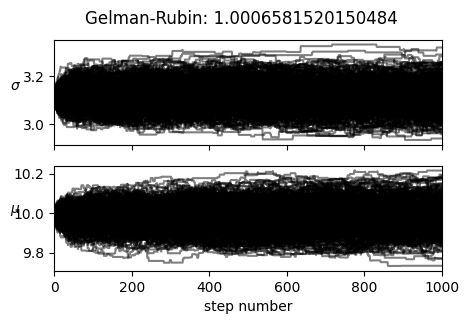

In [9]:
params_mcmc = np.percentile(chains ,50, axis=0)[0,:]
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)
print('Truths:  ',[np.std(data),np.mean(data)])

fig, axes = plt.subplots(len(results.x), figsize=(5, 3), sharex=True)
labels = ["$\sigma$", "$\mu$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(chains)[0]))
for i in range(len(results.x)):
    ax = axes[i]
    ax.plot(chains[:,:,i], 'k', alpha=0.5)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
fig.show()

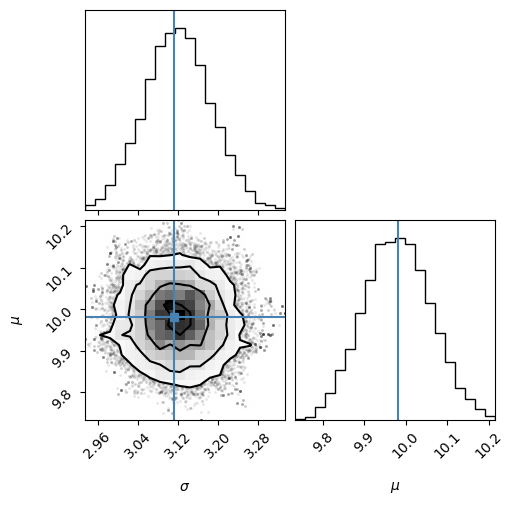

In [10]:
#truths = np.percentile(chains ,50, axis=0)[0,:]
truths = [np.std(data),np.mean(data)]
labels = ["$\sigma$", "$\mu$"]

figure = corner.corner(flat_samples, labels=labels, truths=truths)

In [11]:
df = pd.read_csv('./pleiades/data/pleiades_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = 19.997, -45.548
rango = 10
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.004) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]
print(len(df))

(86964, 20)
1965


In [12]:
def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

nll = lambda *args: -log_likelihood(*args)

In [13]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-5231.594395211177
0.0
-5231.594395211177


array([ 0.48829093,  1.03814666,  4.98350399, 19.93836987, 19.8259093 ])

In [14]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-5478.562789421741
0.0
-5478.562789421741


array([  0.37604539,   1.07247782,   4.83730377, -45.45737134,
       -44.12901859])

Text(0.5, 0, 'pmdec')

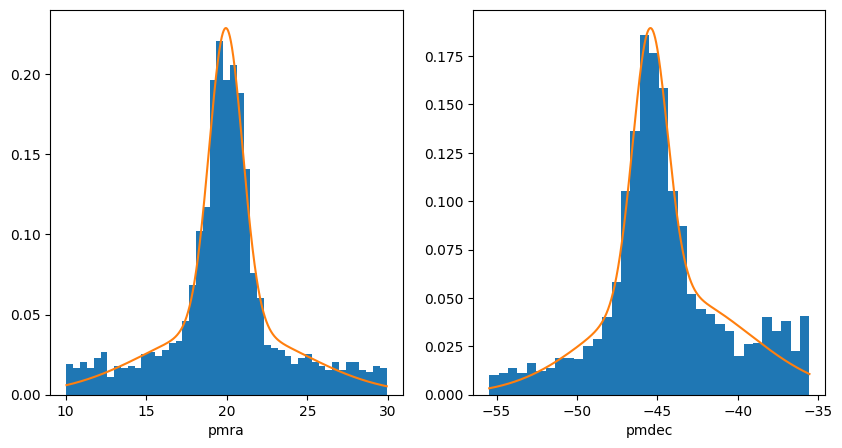

In [15]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [16]:
initparams = results_pmra.x
params, data = initparams, df.pmra 
n_iter, n_walkers, n_dim = 1000, 100, 5
a = 0.01

sampler = mcmc(params=initparams, data=data, n_iter=n_iter, n_walkers=n_walkers, n_dim=n_dim, a=a)

In [17]:
chains_pmra = sampler.run_mcmc()
print(chains_pmra.shape)

100%|█████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]

(1000, 100, 5)


In [23]:
flat_samples_pmra = sampler.get_chain(chains_pmra, burn_in=150, thin=10)
flat_samples_pmra.shape

(8500, 5)

Text(0.5, 0, 'step number')

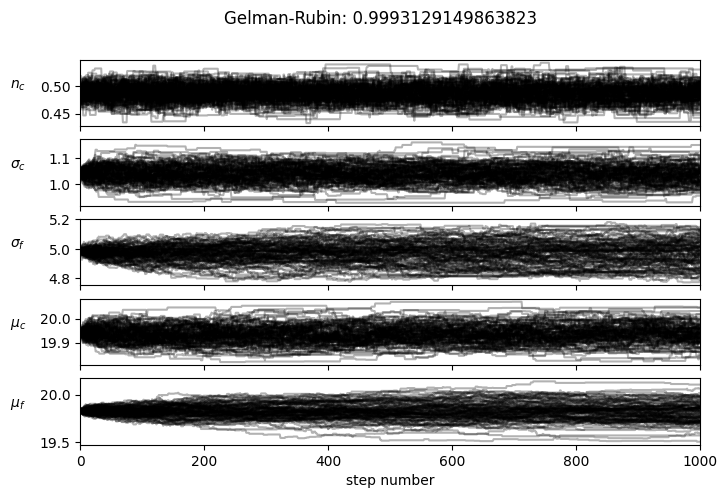

In [24]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(chains_pmra)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(chains_pmra[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains_pmra))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

<Figure size 800x800 with 0 Axes>

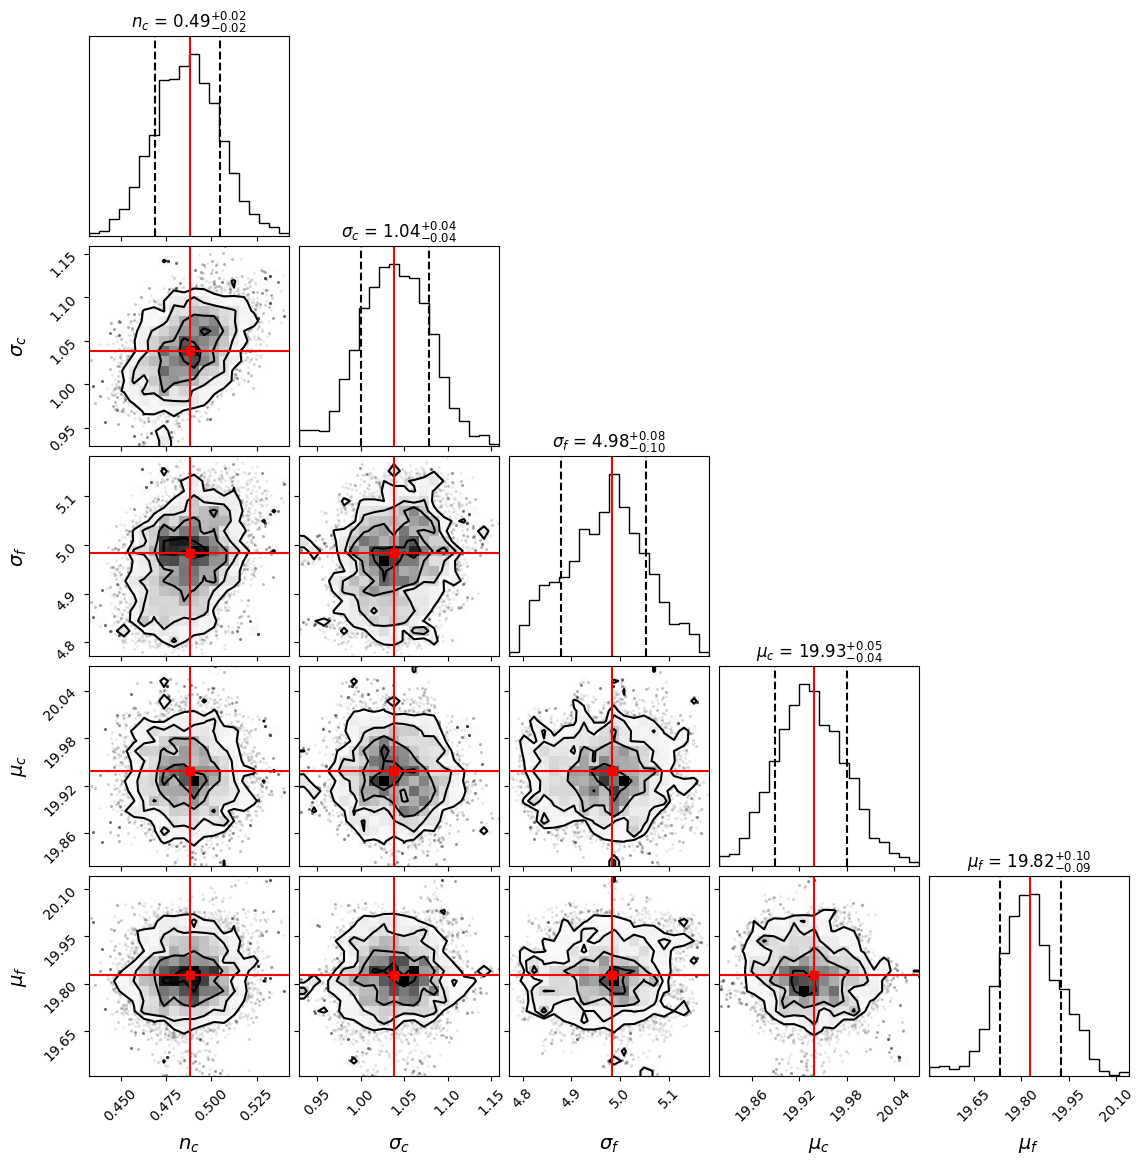

In [25]:
truths = results_pmra.x
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples_pmra, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12},label_kwargs=dict(fontsize=14),truth_color='red')

In [21]:
initparams = results_pmdec.x
params, data = initparams, df.pmdec
n_iter, n_walkers, n_dim = 1000, 100, 5
a = 0.01

sampler = mcmc(params=initparams, data=data, n_iter=n_iter, n_walkers=n_walkers, n_dim=n_dim, a=a)

In [22]:
chains_pmdec = sampler.run_mcmc()
print(chains_pmdec.shape)

100%|█████████████████████████████████████████| 100/100 [03:24<00:00,  2.04s/it]

(1000, 100, 5)


In [26]:
flat_samples_pmdec = sampler.get_chain(chains_pmdec, burn_in=150, thin=10)
flat_samples_pmdec.shape

(8500, 5)

Text(0.5, 0, 'step number')

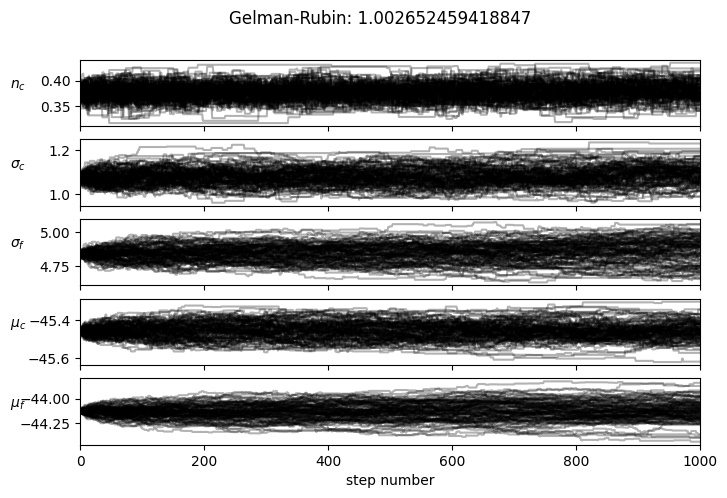

In [27]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(chains_pmdec)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(chains_pmdec[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains_pmdec))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

In [34]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, data):
    x, y = data
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, data):
    x, y = data
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, data)

In [38]:
x = df.pmra
y = df.pmdec
data = [x, y]
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, data))
print(log_prior(initparams))
print(log_probability(initparams, data))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(data), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 1.038146655237542, 4.983503993721438, 4.83730376754177, -0.14073419454276262, 19.9383698667556, -45.45737134256799, 19.825909303867967, -44.12901859117876]
-10019.223863088484
0.0
-10019.223863088484


array([  0.47772208,   1.1112222 ,   4.93604621,   5.21740536,
        -0.13975546,  19.94654804, -45.41058935,  19.8206177 ,
       -43.91303715])

In [46]:
initparams = results.x
params, data = initparams, [df.pmra, df.pmdec]
n_iter, n_walkers, n_dim = 5000, 100, 9
a = 0.01

sampler = mcmc(params=initparams, data=data, n_iter=n_iter, n_walkers=n_walkers, n_dim=n_dim, a=a)

In [47]:
chains_pm = sampler.run_mcmc()
print(chains_pm.shape)

100%|█████████████████████████████████████████| 100/100 [31:23<00:00, 18.83s/it]

(5000, 100, 9)


In [48]:
flat_samples_pm = sampler.get_chain(chains_pm, burn_in=150, thin=10)
flat_samples_pm.shape

(48500, 9)

Text(0.5, 0, 'step number')

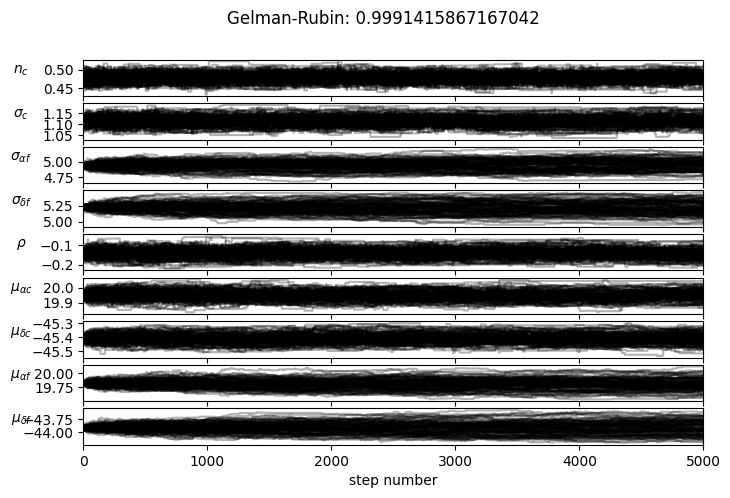

In [49]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_{\\alpha f}$", "$\sigma_{\delta f}$", "$\\rho$",
          "$\mu_{\\alpha c}$", "$\mu_{\delta c}$", "$\mu_{\\alpha f}$", "$\mu_{\delta f}$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(chains_pm)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(chains_pm[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains_pm))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

<Figure size 800x800 with 0 Axes>

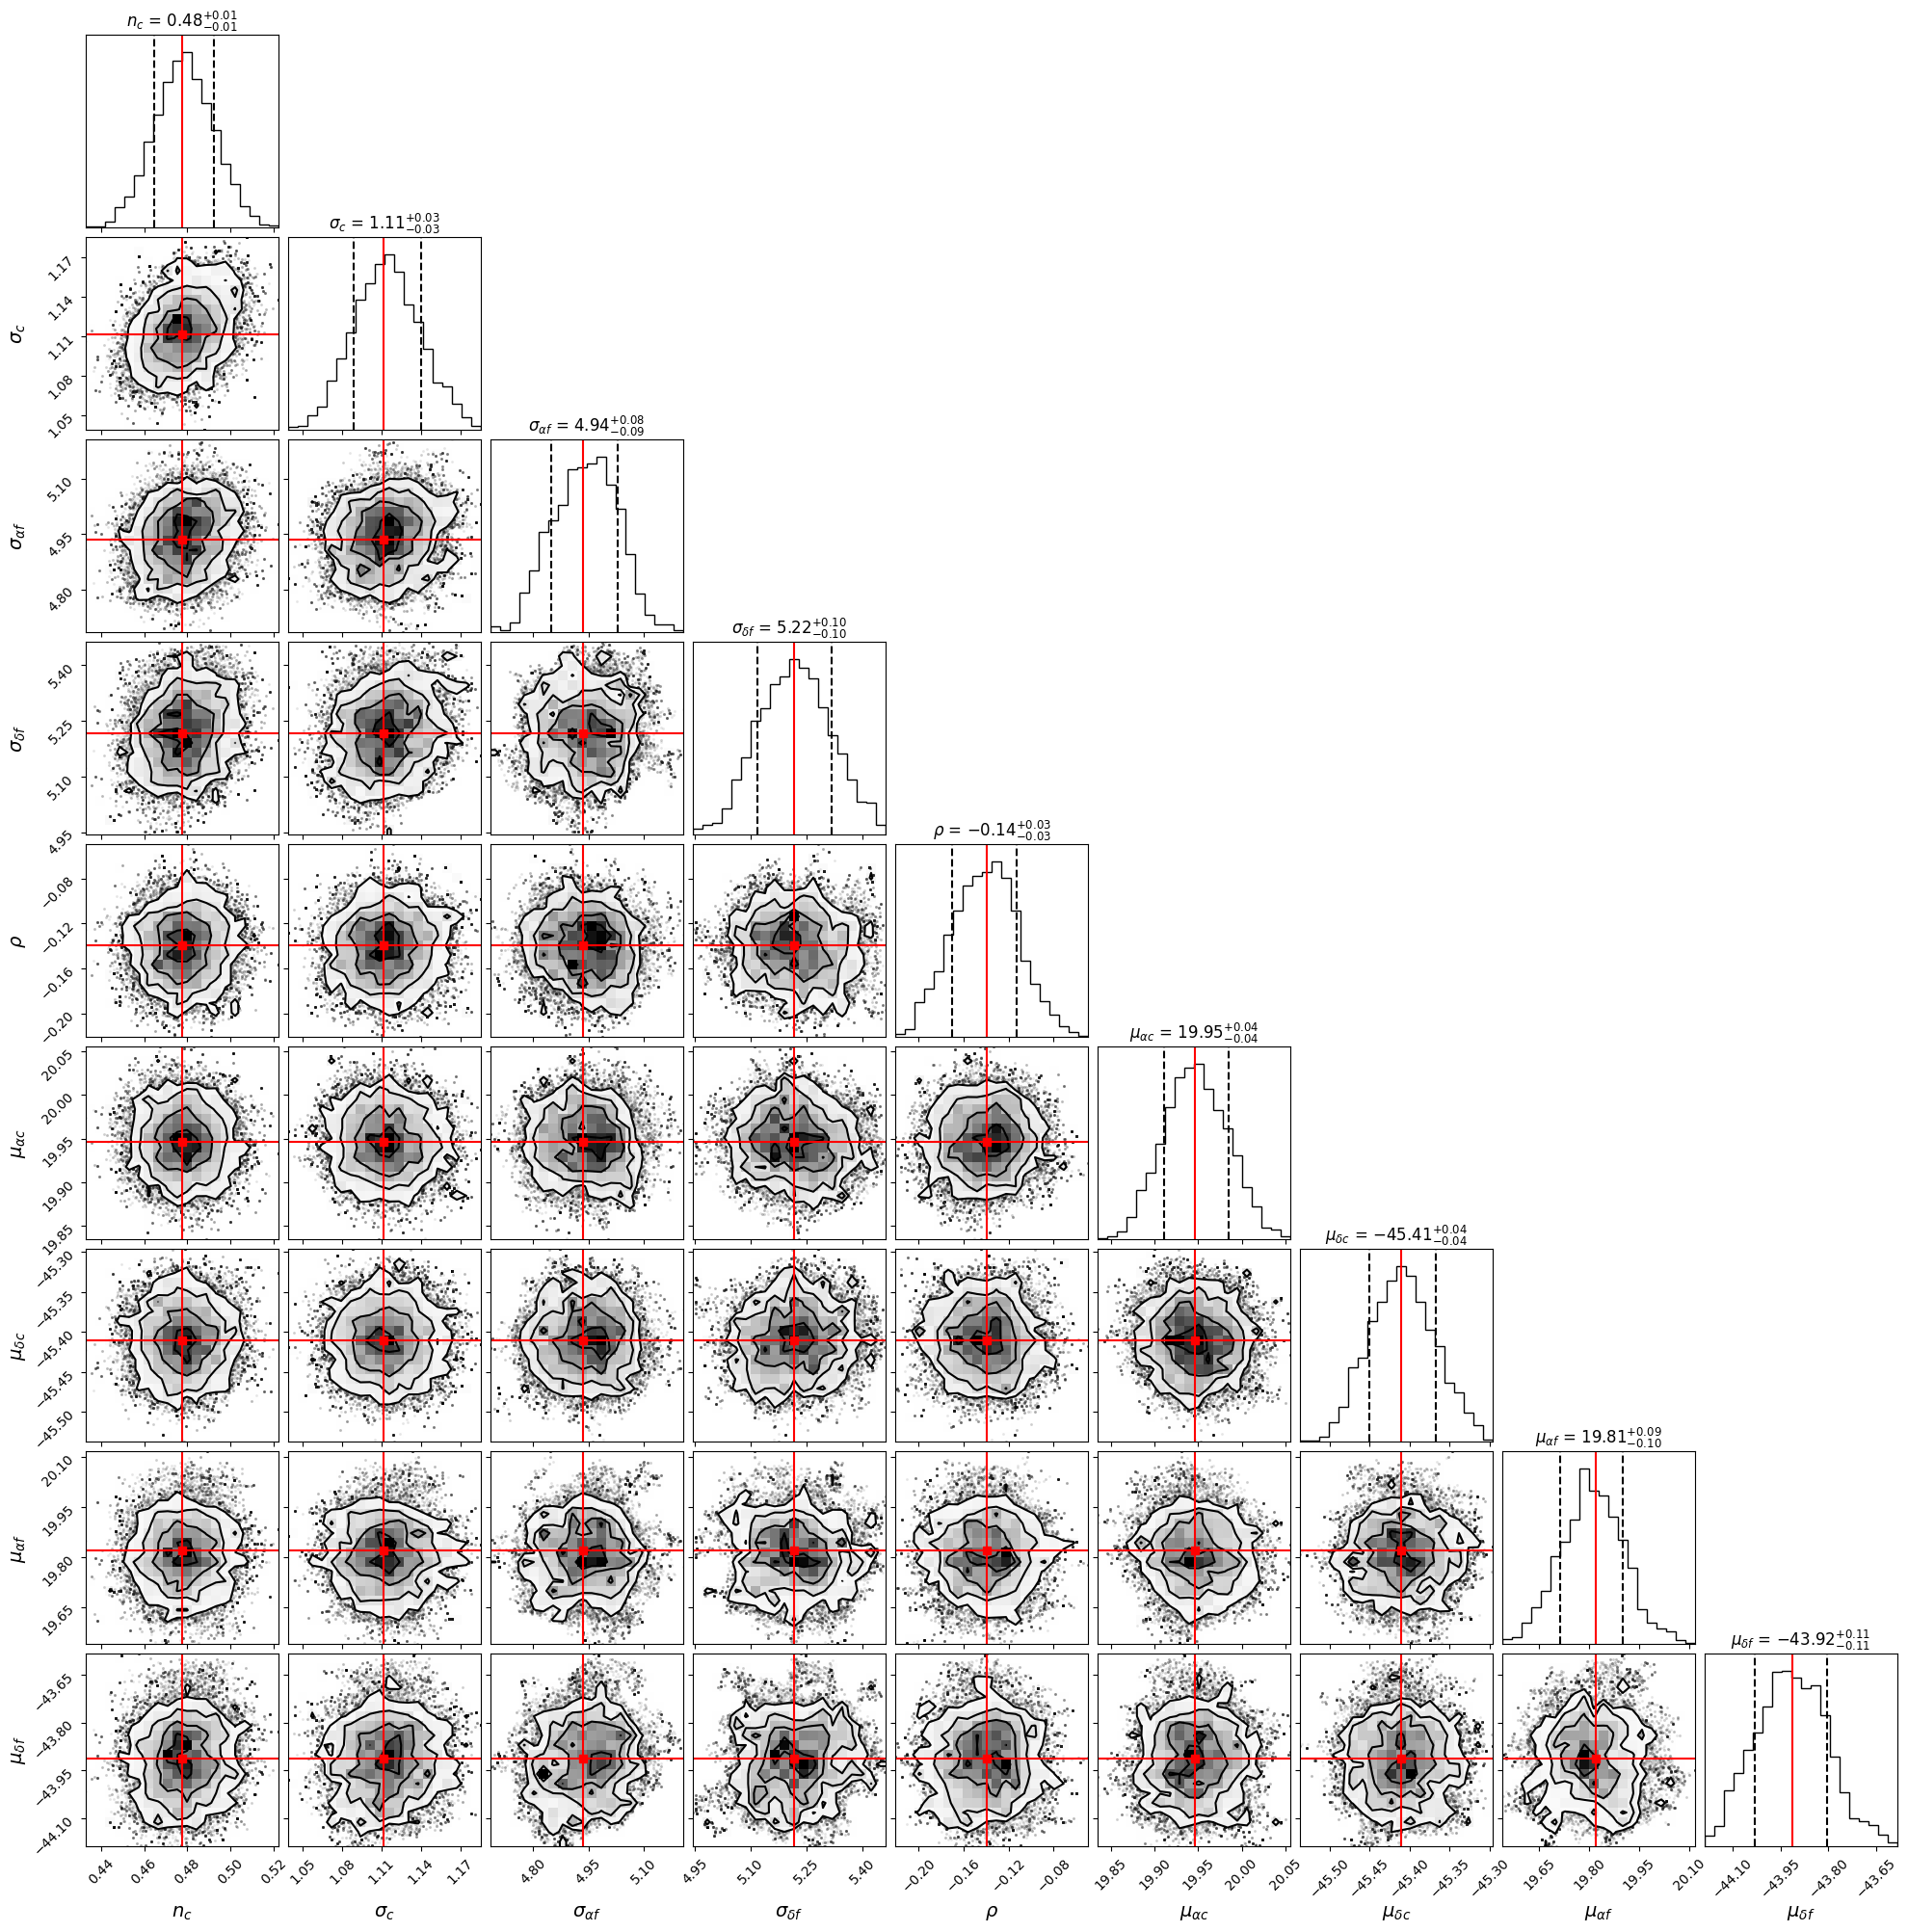

In [50]:
truths = results.x
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples_pm, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12},label_kwargs=dict(fontsize=14),truth_color='red')